# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines. We will utilize a dataset related to marketing bank products over the telephone.


### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing). The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns. We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.


### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper. How many marketing campaigns does this data represent?


Ans :- 7 Marketing campaigns


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.


In [1]:
import pandas as pd
import time
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import ydata_profiling as df_report

from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
import seaborn as sns
import plotly.express as px
import matplotlib as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime
import sweetviz as sv
from sklearn.metrics import auc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import kds

In [2]:
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features

Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.

```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```


In [4]:
df_bank_data = df
df_bank_data.rename(columns={'housing': 'housing_loan', 'loan': 'personal_loan', 'campaign': 'current_campaign_contact_counts',
                    'previous': 'previous_campaign_contact_counts', 'pdays': 'days_after_last_campaigncontact', 'default': 'credit_default'}, inplace=True)
display(df_bank_data.columns)

Index(['age', 'job', 'marital', 'education', 'credit_default', 'housing_loan',
       'personal_loan', 'contact', 'month', 'day_of_week', 'duration',
       'current_campaign_contact_counts', 'days_after_last_campaigncontact',
       'previous_campaign_contact_counts', 'poutcome', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the _Business Objective_ of the task. State the objective below.


In [5]:
df_bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   age                               41188 non-null  int64  
 1   job                               41188 non-null  object 
 2   marital                           41188 non-null  object 
 3   education                         41188 non-null  object 
 4   credit_default                    41188 non-null  object 
 5   housing_loan                      41188 non-null  object 
 6   personal_loan                     41188 non-null  object 
 7   contact                           41188 non-null  object 
 8   month                             41188 non-null  object 
 9   day_of_week                       41188 non-null  object 
 10  duration                          41188 non-null  int64  
 11  current_campaign_contact_counts   41188 non-null  int64  
 12  days

Business Objective:

The goal of this exercise is to build a classifier that can predict whether a client will subscribe for the long term deposit given we know certain types of information about the client ( as per the data set )


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started. Before we can do this, we must work to encode the data. Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.


In [6]:
# Doing some quick EDA using Sweetviz
data_report = sv.analyze(df_bank_data)
#display the report
data_report.show_html('eda-report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report eda-report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [7]:
# selecting only the first 7 columns and output feature
df_bank_features_only = df_bank_data.loc[:, ['age', 'job', 'marital', 'education', 'credit_default', 'housing_loan',
                                             'personal_loan', 'y']]

# apply one-hot encoding to categorical columns
categorical_ohe_features = ['job', 'marital', 'education',
                            'credit_default', 'housing_loan', 'personal_loan']
df_bank_features_only = pd.get_dummies(
    df_bank_features_only, columns=categorical_ohe_features)
# apply standard scaling to numerical columns
scaler = StandardScaler()
df_bank_features_only['age'] = scaler.fit_transform(
    df_bank_features_only[['age']])

# apply binary encoding to binary columns
binarizer = LabelBinarizer()
df_bank_features_only['y'] = binarizer.fit_transform(
    df_bank_features_only['y'])

# quick check on the output of the transforms
display(df_bank_features_only.head(5))

,age,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,education_unknown,credit_default_no,credit_default_unknown,credit_default_yes,housing_loan_no,housing_loan_unknown,housing_loan_yes,personal_loan_no,personal_loan_unknown,personal_loan_yes
0,1.533034,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,1.628993,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,1,0,0
2,-0.290186,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
3,-0.002309,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,1.533034,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.


In [8]:
X = df_bank_features_only.drop('y', axis=1)
y = df_bank_features_only['y']

# Taking out a test set before resampling to mitigate class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Check for class imbalance on the output variable in training data and test data
print("Check for class imbalance in training set : \n {}".format(
    pd.DataFrame(y_train).value_counts()))

print("Check for class imbalance in test set : \n {}".format(
    pd.DataFrame(y_test).value_counts()))


# Re-balancing only the train data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

display(X_train_res.head())
display(pd.DataFrame(y_train_res).value_counts())
print("Check for class imbalance in training set after resampling : \n {}".format(
    pd.DataFrame(y_train_res).value_counts()))

Check for class imbalance in training set : 
 y
0    29245
1     3705
dtype: int64
Check for class imbalance in test set : 
 y
0    7303
1     935
dtype: int64


,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,education_unknown,credit_default_no,credit_default_unknown,credit_default_yes,housing_loan_no,housing_loan_unknown,housing_loan_yes,personal_loan_no,personal_loan_unknown,personal_loan_yes
0,-0.002309,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1,-0.865939,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1.820911,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,0.285568,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
4,-0.098268,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0


y
0    29245
1    29245
dtype: int64

Check for class imbalance in training set after resampling : 
 y
0    29245
1    29245
dtype: int64


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline. What is the baseline performance that our classifier should aim to beat?


In [9]:
# Function to train and evaluate a classifiers performance=

def train_and_evaluate_classifier(clf, X_train_clf, y_train_clf, X_test, y_test):
    start = time.time()
    clf.fit(X_train_clf, y_train_clf)
    stop = time.time()
    training_time = stop - start
    train_score = clf.score(X_train_clf, y_train_clf)
    test_score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    return train_score, test_score, accuracy, precision, recall, f1, training_time


In [10]:
results = []  # A list to store all the results of classifers

dummy_clf = DummyClassifier(strategy="most_frequent")

train_score, test_score, accuracy, precision, recall, f1, train_time = train_and_evaluate_classifier(
    dummy_clf, X_train_res, y_train_res, X_test, y_test)
results.append({'clf': 'dummy_classifier(most_frequent)', 'train_score': train_score, 'test_score': test_score, 'f1_score': f1,
               'accuracy_score': accuracy, 'recall_score': recall, 'precision_score': precision, 'train_time': train_time})

# Evaluate the performance of the dummy classifier
print("Performance of baseline dummy most frequent class predictor classifier")
display(pd.DataFrame(results).head())
print("The classifiers we are building should aim to beat the f1 score and recall of the baseline classfier")


Performance of baseline dummy most frequent class predictor classifier


/Users/ageorge/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,clf,train_score,test_score,f1_score,accuracy_score,recall_score,precision_score,train_time
0,dummy_classifier(most_frequent),0.5,0.886502,0.0,0.886502,0.0,0.0,0.003419


The classifiers we are building should aim to beat the f1 score and recall of the baseline classfier


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.


In [11]:
logreg_clf = LogisticRegression(max_iter=10000, random_state=42)

# I am fitting the classifier to the data in a function call that does the fitting and scoring as well

train_score, test_score, accuracy, precision, recall, f1, train_time = train_and_evaluate_classifier(
    logreg_clf, X_train_res, y_train_res, X_test, y_test)
results.append({'clf': 'Logistic Regression', 'train_score': train_score, 'test_score': test_score, 'f1_score': f1,
               'accuracy_score': accuracy, 'recall_score': recall, 'precision_score': precision, 'train_time': train_time})


### Problem 9: Score the Model

What is the accuracy of your model?


In [12]:
print("Performance of logistic regression classifier")
display(pd.DataFrame(results).head())


Performance of logistic regression classifier


,clf,train_score,test_score,f1_score,accuracy_score,recall_score,precision_score,train_time
0,dummy_classifier(most_frequent),0.500000,0.886502,0.00,0.886502,0.00000,0.000000,0.003419
1,Logistic Regression,0.675329,0.697742,0.25,0.697742,0.44385,0.174004,1.624732


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models. Using the default settings for each of the models, fit and score each. Also, be sure to compare the fit time of each of the models. Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------- | ------------- |
|       |            | .              | .             |


In [13]:
DT_clf = DecisionTreeClassifier()

# I am fitting the classifier to the data in a function call that does the fitting and scoring as well

train_score, test_score, accuracy, precision, recall, f1, train_time = train_and_evaluate_classifier(
    DT_clf, X_train_res, y_train_res, X_test, y_test)
results.append({'clf': 'Decision Tree Classifier', 'train_score': train_score, 'test_score': test_score, 'f1_score': f1,
               'accuracy_score': accuracy, 'recall_score': recall, 'precision_score': precision, 'train_time': train_time})
print("Performance of Decision Tree classifier")
display(pd.DataFrame(results).head())


Performance of Decision Tree classifier


,clf,train_score,test_score,f1_score,accuracy_score,recall_score,precision_score,train_time
0,dummy_classifier(most_frequent),0.500000,0.886502,0.000000,0.886502,0.000000,0.000000,0.003419
1,Logistic Regression,0.675329,0.697742,0.250000,0.697742,0.443850,0.174004,1.624732
2,Decision Tree Classifier,0.902188,0.795581,0.218199,0.795581,0.251337,0.192781,0.362557


In [14]:
SVC_clf = SVC()

# I am fitting the classifier to the data in a function call that does the fitting and scoring as well
# using only a few thousands of datapoints for SVM to train quicker
# using the stratified sampling technique to ensure the class imbalance is maintained in the subset of data used for svm
X_train_res_subset, _, y_train_res_subset, _ = train_test_split(
    X_train_res, y_train_res, test_size=0.90, stratify=y_train_res, random_state=42)

print("Check for class imbalance in sub-sampled training set : \n {}".format(
    pd.DataFrame(y_train_res_subset).value_counts()))

train_score, test_score, accuracy, precision, recall, f1, train_time = train_and_evaluate_classifier(
    SVC_clf, X_train_res_subset, y_train_res_subset, X_test, y_test)

results.append({'clf': 'Support Vector Classifier', 'train_score': train_score, 'test_score': test_score, 'f1_score': f1,
               'accuracy_score': accuracy, 'recall_score': recall, 'precision_score': precision, 'train_time': train_time})

print("Performance of Decision Tree classifier")
display(pd.DataFrame(results).head())

Check for class imbalance in sub-sampled training set : 
 y
1    2925
0    2924
dtype: int64
Performance of Decision Tree classifier


,clf,train_score,test_score,f1_score,accuracy_score,recall_score,precision_score,train_time
0,dummy_classifier(most_frequent),0.500000,0.886502,0.000000,0.886502,0.000000,0.000000,0.003419
1,Logistic Regression,0.675329,0.697742,0.250000,0.697742,0.443850,0.174004,1.624732
2,Decision Tree Classifier,0.902188,0.795581,0.218199,0.795581,0.251337,0.192781,0.362557
3,Support Vector Classifier,0.703710,0.662661,0.265009,0.662661,0.535829,0.176037,1.758747


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these. Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration. For example, should we keep the gender feature? Why or why not?
- Hyperparameter tuning and grid search. All of our models have additional hyperparameters to tune and explore. For example the number of neighbors in KNN or the maximum depth of a Decision Tree.
- Adjust your performance metric


In [15]:
# Hyper parameter tuning through grid search, the following are the parameters I want to run through for each classifier
knn_params = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 20, 25, 30]}
logreg_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
tree_params = {'max_depth': [None, 2, 3, 4, 5, 10, 20, 25]}
# svc_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svc_params = {'C': [ 0.01, 0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001],
            #   'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
                'kernel': ['linear', 'poly', 'sigmoid']}
# Define base classifiers
knn_clf = KNeighborsClassifier()
logreg_clf = LogisticRegression(max_iter=10000)
tree_clf = DecisionTreeClassifier()
svc_clf = SVC(probability=True)
# Define the parameter grids for each classifier
param_grids = {'KNN': knn_params, 'Logistic Regression': logreg_params,
               'DTree': tree_params, 'SVC': svc_params}

scorer = make_scorer(recall_score)


# Define evaluating the best tuned classifier

grid_results = []
models = []

for clf_name, clf in {'KNN': knn_clf, 'Logistic Regression': logreg_clf, 'DTree': tree_clf, 'SVC': svc_clf}.items():
    print("Tuning {} Classifier".format(clf_name))
    if clf_name == 'SVC':
        X_train_res_subset, _, y_train_res_subset, _ = train_test_split(
            X_train_res, y_train_res, test_size=0.95, stratify=y_train_res, random_state=42)
        gs = GridSearchCV(clf, param_grids[clf_name], cv=5)
        print("starting svm grid fit at {}".format(datetime.now()))
        gs.fit(X_train_res_subset, y_train_res_subset)
        print("finished svm grid fit at {}".format(datetime.now()))
        X_train_res_subset, _, y_train_res_subset, _ = train_test_split(
            X_train_res, y_train_res, test_size=0.90, stratify=y_train_res, random_state=42)
        train_score, test_score, accuracy, precision, recall, f1, train_time = train_and_evaluate_classifier(
            gs.best_estimator_, X_train_res_subset, y_train_res_subset, X_test, y_test)
        

    else:
        gs = GridSearchCV(clf, param_grids[clf_name], cv=5, scoring='f1')
        gs.fit(X_train, y_train)
        train_score, test_score, accuracy, precision, recall, f1, train_time = train_and_evaluate_classifier(
            gs.best_estimator_, X_train_res, y_train_res, X_test, y_test)

    grid_results.append({'clf': clf_name, 'train_score': train_score, 'test_score': test_score, 'f1_score': f1,
                         'accuracy_score': accuracy, 'recall_score': recall, 'precision_score': precision, 'avg_fit_time': gs.cv_results_['mean_fit_time'].mean(),'hyper_params':gs.best_params_})
    
grid_results_df = pd.DataFrame(grid_results)

display(grid_results_df.head())


Tuning KNN Classifier
Tuning Logistic Regression Classifier
Tuning DTree Classifier
Tuning SVC Classifier
starting svm grid fit at 2023-05-20 13:05:49.852230
finished svm grid fit at 2023-05-20 13:30:03.005699


,clf,train_score,test_score,f1_score,accuracy_score,recall_score,precision_score,avg_fit_time,hyper_params
0,KNN,0.856711,0.803108,0.184925,0.803108,0.196791,0.174408,0.016172,{'n_neighbors': 1}
1,Logistic Regression,0.613250,0.554139,0.252696,0.554139,0.664171,0.156030,0.200342,{'C': 0.0001}
2,DTree,0.902188,0.794853,0.216867,0.794853,0.250267,0.191333,0.057829,{'max_depth': None}
3,SVC,0.674816,0.693372,0.252663,0.693372,0.456684,0.174642,6.005546,"{'C': 10, 'gamma': 1, 'kernel': 'linear'}"


In [16]:
# Trying to add additional features from the social and economic context attributes
df_additional_features = df_bank_data.loc[:, ['age', 'job', 'marital', 'education', 'credit_default', 'housing_loan',
                                                        'personal_loan', 'emp.var.rate',
                                                        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
                                                         'days_after_last_campaigncontact', 'previous_campaign_contact_counts',
                                                        'poutcome', 'y']]

# apply one-hot encoding to categorical columns
categorical_ohe_features = ['job', 'marital', 'education',
                             'credit_default', 'housing_loan', 'personal_loan', 'poutcome']
df_additional_features = pd.get_dummies(
    df_additional_features, columns=categorical_ohe_features)
# apply standard scaling to numerical columns
scaler = StandardScaler()
scaler_features = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
                    'days_after_last_campaigncontact', 'previous_campaign_contact_counts']
df_additional_features[scaler_features] = scaler.fit_transform(df_additional_features[scaler_features])

# apply binary encoding to binary columns
binarizer = LabelBinarizer()
df_additional_features['y'] = binarizer.fit_transform(
     df_additional_features['y'])
display(df_additional_features.head())


,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,days_after_last_campaigncontact,previous_campaign_contact_counts,y,job_admin.,...,credit_default_yes,housing_loan_no,housing_loan_unknown,housing_loan_yes,personal_loan_no,personal_loan_unknown,personal_loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.533034,0.648092,0.722722,0.886447,0.71246,0.33168,0.195414,-0.349494,0,0,...,0,1,0,0,1,0,0,0,1,0
1,1.628993,0.648092,0.722722,0.886447,0.71246,0.33168,0.195414,-0.349494,0,0,...,0,1,0,0,1,0,0,0,1,0
2,-0.290186,0.648092,0.722722,0.886447,0.71246,0.33168,0.195414,-0.349494,0,0,...,0,0,0,1,1,0,0,0,1,0
3,-0.002309,0.648092,0.722722,0.886447,0.71246,0.33168,0.195414,-0.349494,0,1,...,0,1,0,0,1,0,0,0,1,0
4,1.533034,0.648092,0.722722,0.886447,0.71246,0.33168,0.195414,-0.349494,0,0,...,0,1,0,0,0,0,1,0,1,0


In [17]:
# Train test split and resampling
X = df_additional_features.drop('y', axis=1)
y = df_additional_features['y']

# Taking out a test set before resampling to mitigate class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Check for class imbalance on the output variable in training data and test data
print("Check for class imbalance in training set : \n {}".format(
    pd.DataFrame(y_train).value_counts()))

print("Check for class imbalance in test set : \n {}".format(
    pd.DataFrame(y_test).value_counts()))


# Re-balancing only the train data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

display(X_train_res.head())
display(pd.DataFrame(y_train_res).value_counts())
print("Check for class imbalance in training set after resampling : \n {}".format(
    pd.DataFrame(y_train_res).value_counts()))

Check for class imbalance in training set : 
 y
0    29245
1     3705
dtype: int64
Check for class imbalance in test set : 
 y
0    7303
1     935
dtype: int64


,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,days_after_last_campaigncontact,previous_campaign_contact_counts,job_admin.,job_blue-collar,...,credit_default_yes,housing_loan_no,housing_loan_unknown,housing_loan_yes,personal_loan_no,personal_loan_unknown,personal_loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,-0.002309,0.839061,0.591424,-0.474791,0.771846,0.845170,0.195414,-0.349494,0,1,...,0,0,0,1,1,0,0,0,1,0
1,-0.865939,-1.197935,-1.179380,-1.231034,-1.370650,-0.940281,0.195414,-0.349494,1,0,...,0,1,0,0,1,0,0,0,1,0
2,1.820911,-1.197935,-1.179380,-1.231034,-1.307228,-0.940281,0.195414,1.671136,0,0,...,0,1,0,0,1,0,0,1,0,0
3,0.285568,0.839061,0.591424,-0.474791,0.772422,0.845170,0.195414,-0.349494,0,0,...,0,0,0,1,1,0,0,0,1,0
4,-0.098268,0.648092,0.722722,0.886447,0.714190,0.331680,0.195414,-0.349494,1,0,...,0,1,0,0,1,0,0,0,1,0


y
0    29245
1    29245
dtype: int64

Check for class imbalance in training set after resampling : 
 y
0    29245
1    29245
dtype: int64


In [18]:
# Running grid search -- probably need to make this into a function

grid_results = []
models = []
for clf_name, clf in {'KNN': knn_clf, 'Logistic Regression': logreg_clf, 'DTree': tree_clf, 'SVC': svc_clf}.items():
    print("Tuning {} Classifier".format(clf_name))
    if clf_name == 'SVC':
    
        X_train_res_subset, _, y_train_res_subset, _ = train_test_split(
            X_train_res, y_train_res, test_size=0.95, stratify=y_train_res, random_state=42)
        gs = GridSearchCV(clf, param_grids[clf_name], cv=5)
        print("starting svm grid fit at {}".format(datetime.now()))
        gs.fit(X_train_res_subset, y_train_res_subset)
        print("finished svm grid fit at {}".format(datetime.now()))
        X_train_res_subset, _, y_train_res_subset, _ = train_test_split(
            X_train_res, y_train_res, test_size=0.90, stratify=y_train_res, random_state=42)
        train_score, test_score, accuracy, precision, recall, f1, train_time = train_and_evaluate_classifier(
            gs.best_estimator_, X_train_res_subset, y_train_res_subset, X_test, y_test)

    else:
        gs = GridSearchCV(clf, param_grids[clf_name], cv=5, scoring='f1')
        gs.fit(X_train, y_train)
        train_score, test_score, accuracy, precision, recall, f1, train_time = train_and_evaluate_classifier(
            gs.best_estimator_, X_train_res, y_train_res, X_test, y_test)

    grid_results.append({'clf': clf_name, 'train_score': train_score, 'test_score': test_score, 'f1_score': f1,
                         'accuracy_score': accuracy, 'recall_score': recall, 'precision_score': precision, 'avg_fit_time': gs.cv_results_['mean_fit_time'].mean(),'hyper_params':gs.best_params_})
    models.append({'clf':clf_name,'model':gs.best_estimator_})
grid_results_df = pd.DataFrame(grid_results)

display(grid_results_df.head())

Tuning KNN Classifier
Tuning Logistic Regression Classifier
Tuning DTree Classifier
Tuning SVC Classifier
starting svm grid fit at 2023-05-20 13:31:04.343736
finished svm grid fit at 2023-05-20 13:38:36.699500


,clf,train_score,test_score,f1_score,accuracy_score,recall_score,precision_score,avg_fit_time,hyper_params
0,KNN,0.882852,0.765841,0.362735,0.765841,0.587166,0.262428,0.014686,{'n_neighbors': 7}
1,Logistic Regression,0.845546,0.853362,0.414161,0.853362,0.456684,0.378882,0.288336,{'C': 0.1}
2,DTree,0.838742,0.869507,0.457345,0.869507,0.484492,0.433078,0.077846,{'max_depth': 10}
3,SVC,0.836895,0.877276,0.416619,0.877276,0.386096,0.452381,1.829495,"{'C': 10, 'gamma': 1, 'kernel': 'linear'}"


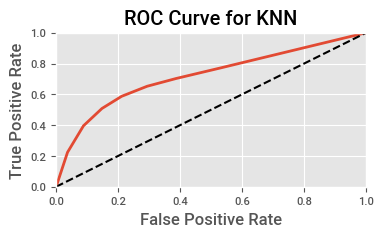

AUC for KNN is 0.72


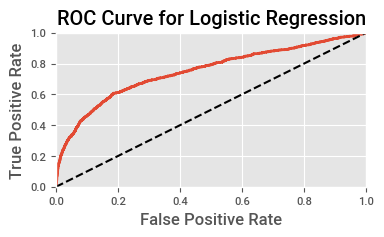

AUC for Logistic Regression is 0.75


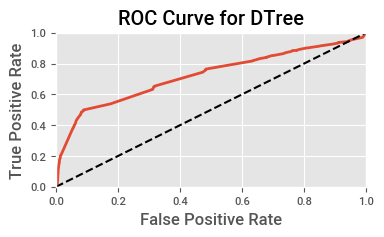

AUC for DTree is 0.72


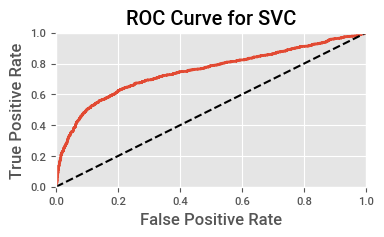

AUC for SVC is 0.75


In [25]:

# Let's plot the ROC curve for the best model
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(4,2),num=label)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for {}'.format(label))
    plt.savefig('images/ROC Curve for {}.png'.format(label),dpi=300,bbox_inches='tight')   
    plt.show()
     
for item in models:

    clf_tree = item['model']
    y_score = clf_tree.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    plot_roc_curve(fpr, tpr, item['clf'])
    print("AUC for {} is {}".format(item['clf'],round(auc(fpr, tpr),2)))
    



Lift and Cumulative Gains Curve for KNN
LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of ev

<Figure size 400x180 with 0 Axes>

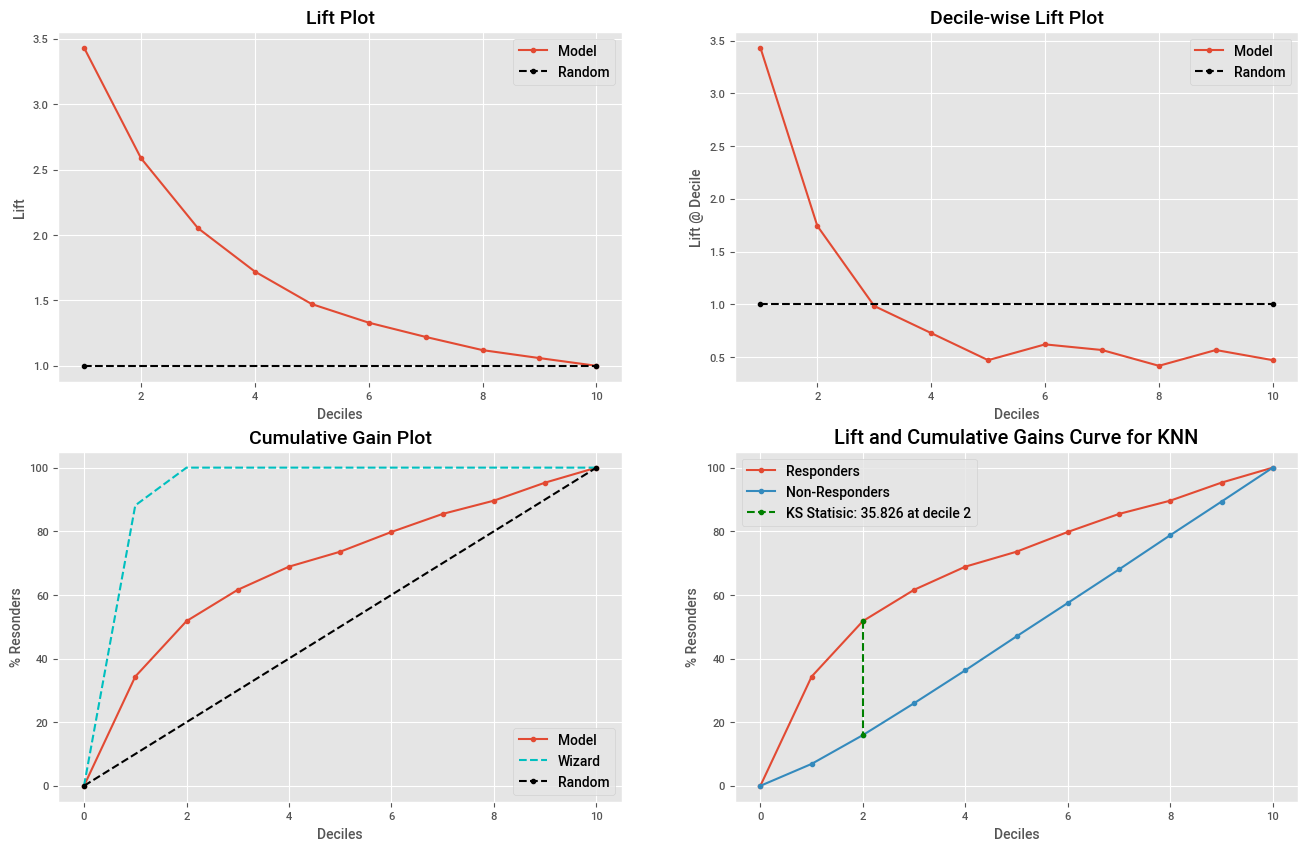

Lift and Cumulative Gains Curve for Logistic Regression
LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of p

<Figure size 640x480 with 0 Axes>

<Figure size 400x180 with 0 Axes>

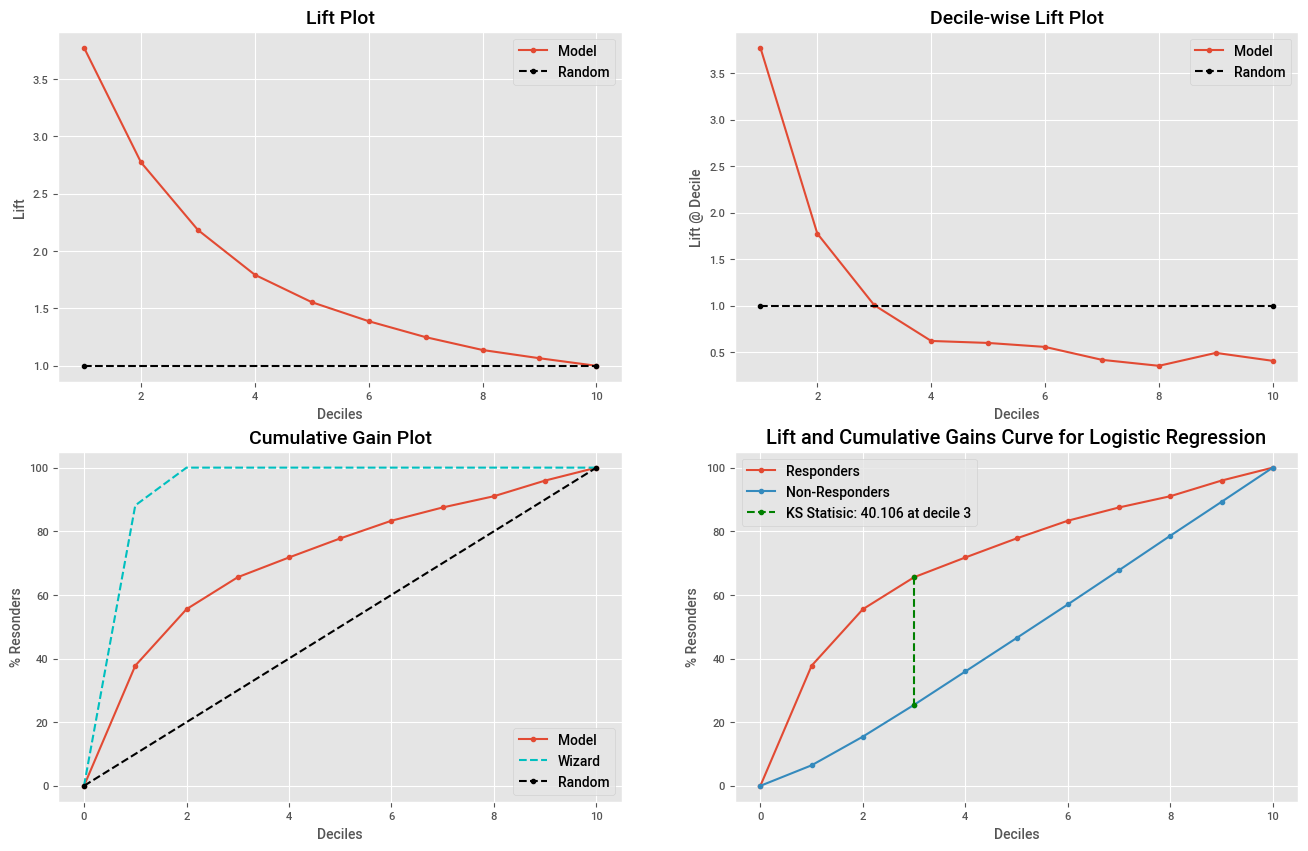

Lift and Cumulative Gains Curve for DTree
LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of 

<Figure size 640x480 with 0 Axes>

<Figure size 400x180 with 0 Axes>

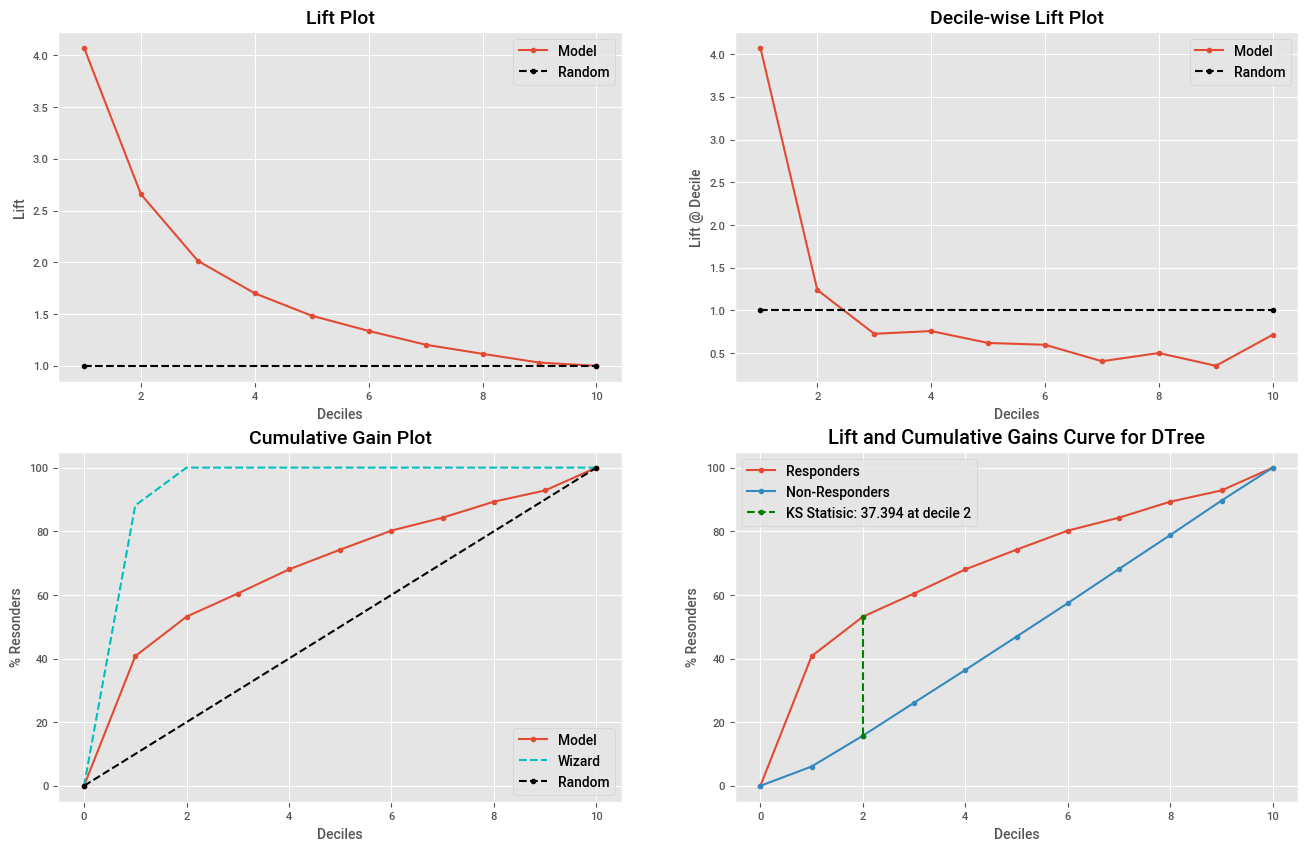

Lift and Cumulative Gains Curve for SVC
LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of ev

<Figure size 640x480 with 0 Axes>

<Figure size 400x180 with 0 Axes>

In [26]:


# Let's plot the lift and cumulative gains curves for the best model

for item in models:
    clf_tree = item['model']
    y_score = clf_tree.predict_proba(X_test)[:,1]
    print("Lift and Cumulative Gains Curve for {}".format(item['clf']))
    plt.figure(figsize=(4,1.8),num=item['clf'])
    kds.metrics.report(y_test, y_score, plot_style='ggplot')
    plt.title('Lift and Cumulative Gains Curve for {}'.format(item['clf'])) 
    plt.show()
    plt.savefig('images/Lift and Cumulative Gains Curve for {}.png'.format(item['clf']),dpi=300,bbox_inches='tight')


Based on the f1 score the best model is Decision Tree. 

I looked at recall as well score since I wanted to minimize the impact of false negatives while maintaining the right balance between not missing out any potential customer who will subscribe for a long term deposit while not calling/following up on every single potential customer. 

Using predict proba threshold can be a way to find the right trade off that business wants to choose from the best model while choosing between true positive rate and false positive rate. 

If we are targetting a certain number of customers for the campaign and there is a significant amount fo cost for each campaign, I recommend looking at the lift curves and identifying a threasholds that have better lift to achieve desired outcomes. 

##### Questions


I wish the problem had a bit more details on the business question. Like, is there a target number they are trying to hit? is there a cost associated with each contact that is made to a potential depositer etc.. so that we know what to optimize for and how to make the best recommendations for those situations. 

Really struggled with long run time of svms while doing hyper parameter tuning